In [1]:
!pip install selenium
!pip install pandas
!pip install beautifulsoup4
!pip install plotly

In [2]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import csv
import plotly.express as px
import os

In [3]:
# FIRST APPROACH WITH BEAUTIFUL SOUP

# I needed to figure out a way to extract the data to a csv file
# This is where i started from, but looks like hltv generates the table after a script, so I will try a different approach

# url = 'https://www.hltv.org/stats/players?startDate=2015-01-01&endDate=2015-12-31&rankingFilter=Top50'
# headers = {
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
# }
# response = requests.get(url, headers=headers)
# soup = BeautifulSoup(response.text, 'html.parser')
# table = soup.find('table', class_='stats-table player-ratings-table')


In [4]:
# SECOND APPROACH USING SELENIUM
# This will take about 5 minutes to run, I wanted to make sure that the pages would load

if not os.path.exists('files'):
    os.makedirs('files')

for year in range(2015,2024):
    # Overall ranking
    filename = f"files/{year}overall.html"
    if not os.path.exists(filename):
        driver = webdriver.Chrome()
        url = f'https://www.hltv.org/stats/players?startDate={year}-01-01&endDate={year}-12-31&rankingFilter=Top20'
        driver.get(url)
        driver.implicitly_wait(10)
        html = driver.page_source
        driver.quit()

        with open(filename, "w", encoding="utf-8") as file:
            file.write(html)
    
    # CT side ranking
    filename = f"files/{year}ctside.html"
    if not os.path.exists(filename):
        driver = webdriver.Chrome()
        url = f'https://www.hltv.org/stats/players?startDate={year}-01-01&endDate={year}-12-31&rankingFilter=Top20&side=COUNTER_TERRORIST'
        driver.get(url)
        driver.implicitly_wait(10)
        html = driver.page_source
        driver.quit()

        with open(filename, "w", encoding="utf-8") as file:
            file.write(html)

    # T side ranking
    filename = f"files/{year}tside.html"
    if not os.path.exists(filename):
        driver = webdriver.Chrome()
        url = f'https://www.hltv.org/stats/players?startDate={year}-01-01&endDate={year}-12-31&rankingFilter=Top20&side=TERRORIST'
        driver.get(url)
        driver.implicitly_wait(10)
        html = driver.page_source
        driver.quit()

        with open(filename, "w", encoding="utf-8") as file:
            file.write(html)


In [5]:
# Basic data manipulation and cleaning
# At the end it will be saved to files/dataframe.csv

def read_table(table, year: int, category :str):

    data = []
    
    rows = table.find('tbody').find_all('tr')
    
    for i, row in enumerate(rows):
        ranking = i + 1

        player_name = row.find('a').text
        country_flag = row.find('img', class_='flag')
        country = country_flag['title'] if country_flag else None
        
        team_name_element = row.find('td', class_='teamCol')
        team_names = []
        team_elements = row.find('td', class_='teamCol').find_all('a')
        for team_element in team_elements:
            img_tag = team_element.find('img')
            if img_tag:
                team_name = img_tag['title']
                team_names.append(team_name)
        team = ', '.join(team_names)

        maps = row.find('td', class_='statsDetail').text
        rounds = row.find('td', class_='statsDetail gtSmartphone-only').text
        kd_diff = row.find('td', class_='kdDiffCol').text
        kd = row.find('td', class_='statsDetail').find_next_sibling().text
        rating = row.find('td', class_='ratingCol').text

        data.append([year, ranking, player_name, country, team, maps, rounds, kd_diff, kd, rating])

    return data

filename = 'files/dataframe.csv'
if not os.path.exists(filename):

    df_final = None
    for year in range(2015, 2024):
        # Overall
        file_path = f"files/{year}overall.html"
        with open(file_path, "r", encoding="utf-8") as file:
            html = file.read()
    
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find('table', class_='stats-table player-ratings-table')
    
        if table:
            data = read_table(table, year, "overall")
            df_overall = pd.DataFrame(data, columns = ["Year", "Ranking", "Name", "Country", "Teams", "Maps", "Rounds","KD Diff", "KD", "Rating"])
        else:
            print(f"No table found for {year} overall")
    
        # CT side
        file_path = f"files/{year}ctside.html"
        with open(file_path, "r", encoding="utf-8") as file:
            html = file.read()
    
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find('table', class_='stats-table player-ratings-table')
    
        if table:
            data = read_table(table, year, "ctside")
            df_ctside = pd.DataFrame(data, columns = ["Year", "CT Ranking", "Name", "Country", "Teams", "CT Maps", "CT Rounds","CT KD Diff", "CT KD", "CT Rating"])
        else:
            print(f"No table found for {year} CT side")
    
        # T side
        file_path = f"files/{year}tside.html"
        with open(file_path, "r", encoding="utf-8") as file:
            html = file.read()
    
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find('table', class_='stats-table player-ratings-table')
    
        if table:
            data = read_table(table, year, "tside")
            df_tside = pd.DataFrame(data, columns = ["Year", "T Ranking", "Name", "Country", "Teams", "T Maps", "T Rounds","T KD Diff", "T KD", "T Rating"])
        else:
            print(f"No table found for {year} T side")
    
        merged_df = pd.merge(df_overall.head(20), df_ctside.drop(columns=['Country', 'Year', 'Teams']), on='Name')
        merged_df = pd.merge(merged_df, df_tside.drop(columns=['Country', 'Year', 'Teams']), on='Name')
    
        # Reorder
        df = merged_df[['Year', 'Name', 'Country', 'Teams', 'Maps', 'Ranking', 'CT Ranking', 'T Ranking', 'Rounds', 'CT Rounds', 'T Rounds', 'KD Diff', 'CT KD Diff', 'T KD Diff', 'KD', 'CT KD', 'T KD', 'Rating', 'CT Rating', 'T Rating']]
        
        if df_final is None:
            df_final = df
        else:
            df_final = pd.concat([df_final, df])
    
    df_final.to_csv(filename, index=False)


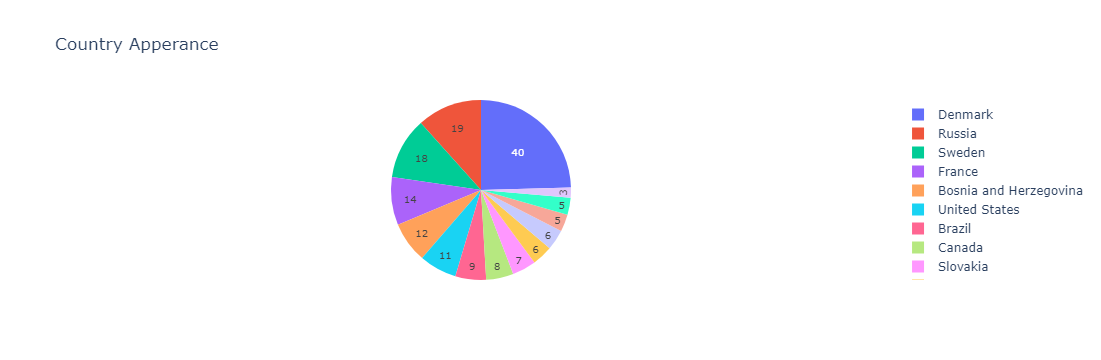

In [20]:
# Shows what country appears more often in the top 20 , only shows countries that appear more than 3 times
df = pd.read_csv('files/dataframe.csv')

df = df['Country'].value_counts()
df = df.to_frame()

df.columns = ["Count"] 

# Filter 2 or less appearances 
df = df[df['Count'] >= 3]

fig = px.pie(df, values='Count', names=df.index, title='Country Apperance')
fig.update_traces(textinfo='value', textfont_size=10)
fig.show()

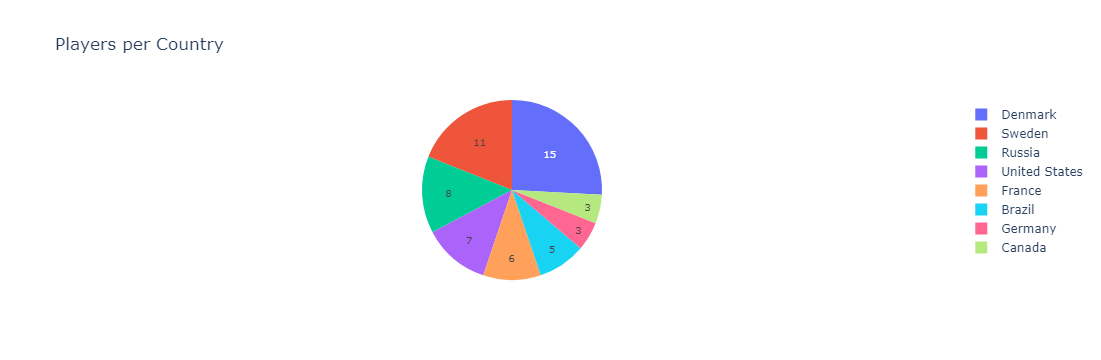

In [21]:
## Unique Players per Country that appeared in the top 20, only shows countries that have more than 3 players appearing in the top 20
df = pd.read_csv('files/dataframe.csv')

df_unique = df.drop_duplicates(subset=['Name'])

# Count the occurrences of each country
country_counts = df_unique['Country'].value_counts()
df_country = country_counts.to_frame()
df_country.columns = ["Count"] 

# Filter 2 or less appearances 
df_country = df_country[df_country['Count'] >= 3]

fig = px.pie(df_country, values='Count', names=df_country.index, title='Players per Country')
fig.update_traces(textinfo='value', textfont_size=10)
fig.show()

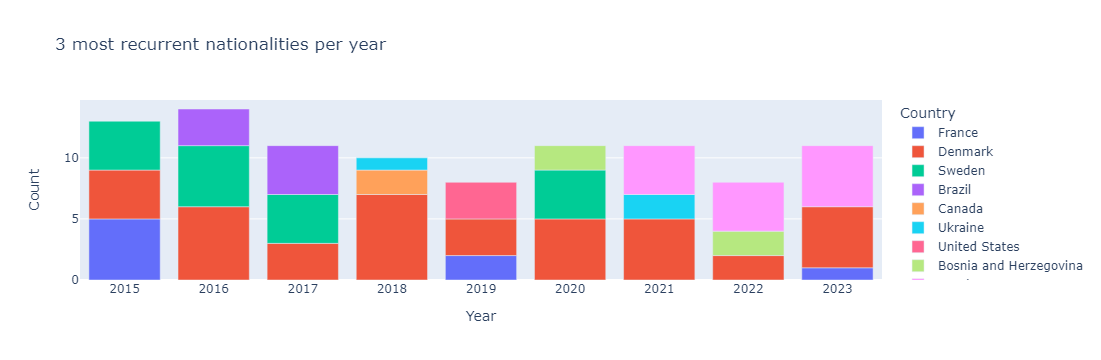

In [22]:
# Displays what 3 coutnries appeared the most on that year
df = pd.read_csv('files/dataframe.csv')

df_grouped = df.groupby('Year')

# Create an empty list to store the top 3 entries for each year
arr_countries = []
for year, group in df_grouped:
    countries = group['Country'].value_counts().head(3).reset_index()
    for i, row in countries.iterrows():
        arr_countries.append((year, row['Country'], row['count']))

df_countries = pd.DataFrame(arr_countries, columns=["Year","Country","Count"])
df_countries_sorted = df_countries.sort_values(by=['Year', 'Count'], ascending=[True, False])

fig = px.bar(df_countries, x="Year", y="Count", color="Country", title="3 most recurrent nationalities per year")
fig.show()

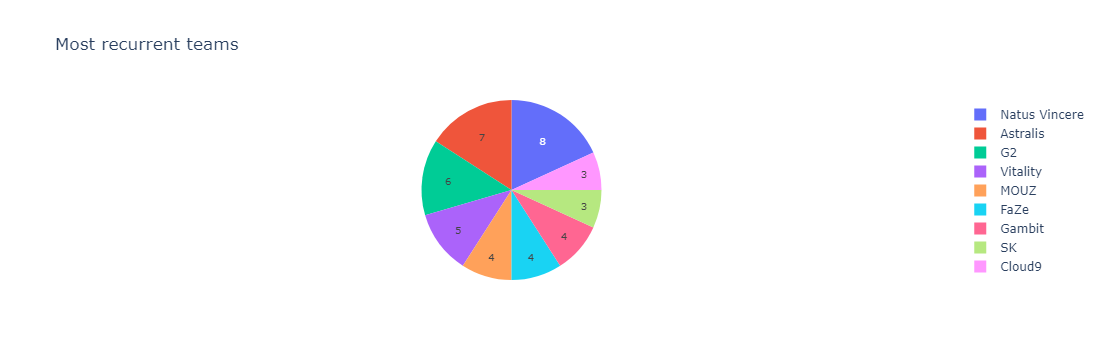

In [24]:
## Show teams the most appeared in the top 5, all years
df = pd.read_csv('files/dataframe.csv')


df_sorted = df.sort_values(by=['Year', 'Ranking'])
grouped = df_sorted.groupby('Year')

# Create an empty list to store the top 5 entries for each year
top5_per_year = []
for year, group in grouped:
    top5 = group.head(5)
    top5_per_year.append(top5)


df_top5 = pd.concat(top5_per_year)
df_top5.reset_index(drop=True, inplace=True)

# Split the 'Teams' column where there are multiple teams listed and remove leading and trailing whitespace
teams_split = df_top5['Teams'].str.split(',').explode().str.strip().reset_index(drop=True)
# Remove the team "(?)" from the Series
teams_split = teams_split[teams_split != "?"]

# Count the number of occurrences of each team
team_counts = teams_split.value_counts()
df_teams = team_counts.to_frame()
df_teams.columns = ["Count"] 

# Filter 2 or less appearances 
df_teams = df_teams[df_teams['Count'] >= 3]

fig = px.pie(df_teams, values='Count', names=df_teams.index, title='Most recurrent teams')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=10)
fig.show()

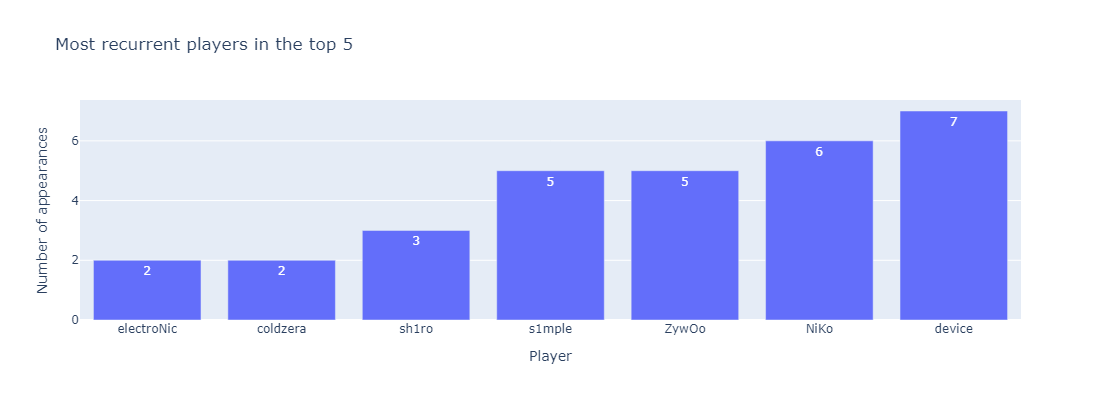

In [50]:
# Show most recurrent top 5 players (2 or more occurrences)
df = pd.read_csv('files/dataframe.csv')

# Stores the top 5 players for each year
top5_per_year = []
for year, group in grouped:
    top5 = group.head(5)
    top5_per_year.append(top5)


df_top5 = pd.concat(top5_per_year)

overall_top_players = df_top5['Name'].value_counts()
df_top_players = overall_top_players.to_frame()

df_top_players = df_top_players.reset_index()

df_top_players.columns = ["Name","Count"] 
df_top_players = df_top_players[df_top_players['Count'] >= 2]
df_top_players = df_top_players.sort_values('Count', ascending=True)

fig = px.bar(df_top_players, x='Name', y='Count', text='Count', height=400,
             title = "Most recurrent players in the top 5", labels={'Name': 'Player', 'Count': 'Number of appearances'})
fig.show()

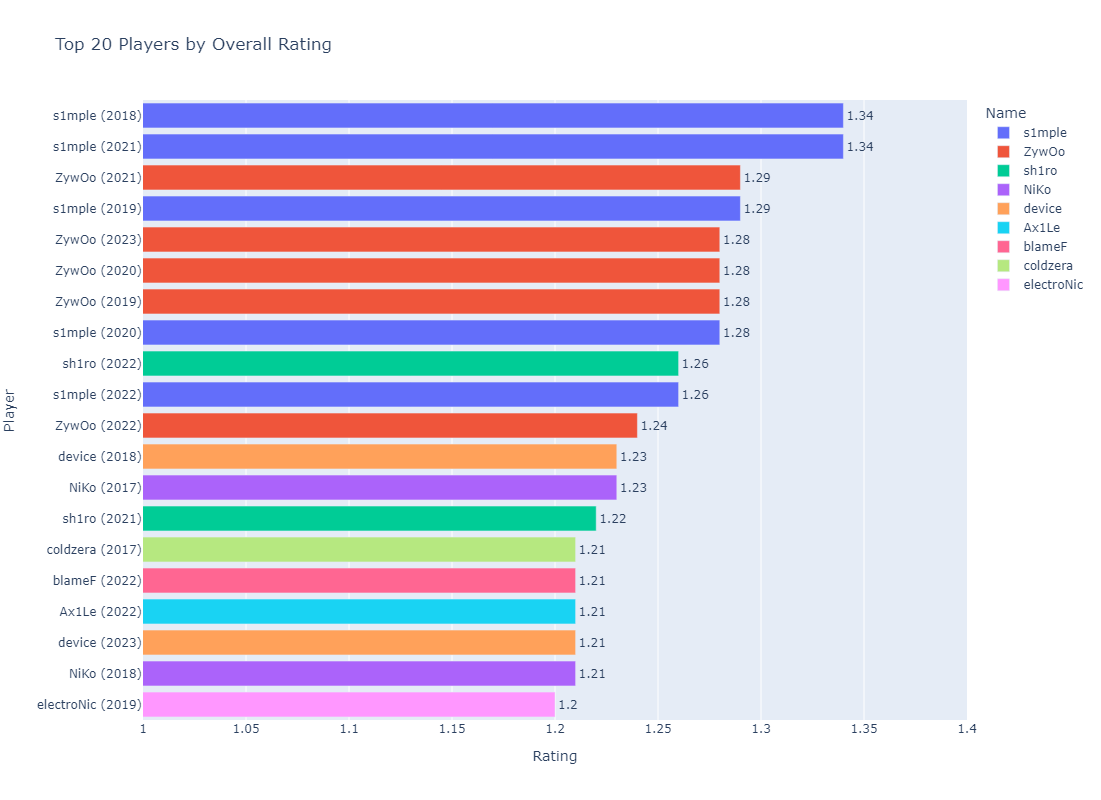

In [56]:
# Show overall top 20 of all time
df = pd.read_csv('files/dataframe.csv')

# Add a unique identifier for each appearance of a player
df['Player ID'] = df['Name'] + ' (' + df['Year'].astype(str) + ')'

# Sort the DataFrame based on 'Rating' column in ascending order
df_sorted = df.sort_values(by='Rating', ascending=False)

# Select the top 10 players based on rating
top20_players = df_sorted.head(20)

fig = px.bar(top20_players, x='Rating', y='Player ID', color='Name', text='Rating',
             labels={'Player ID': 'Player'}, title='Top 20 Players by Overall Rating')

fig.update_traces(textposition='outside')
fig.update_layout(height=800) 
fig.update_yaxes(categoryorder='total ascending')  
fig.update_xaxes(range=[1, 1.4])

fig.show()

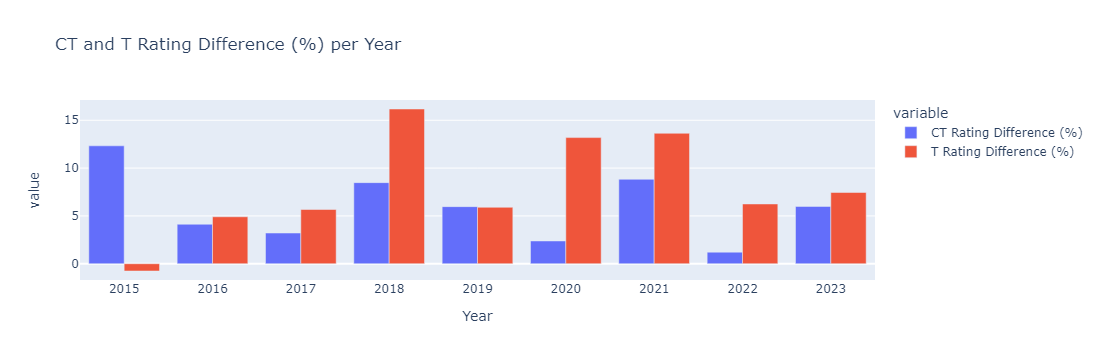

In [66]:
# Top 1 of the year Rating compared (for each side) to the rest of the top 5
df = pd.read_csv('files/dataframe.csv')

unique_years = df['Year'].unique()

# Create a list to store dictionaries for each year
top_players_comparison = []

# Iterate over each unique year
for year in unique_years:
    df_year = df[df['Year'] == year]
    player = df_year.iloc[0]
    
    # Get the average CT Rating and T Rating for the current year
    avg_ct_rating = df_year['CT Rating'].iloc[1:6].mean()
    avg_t_rating = df_year['T Rating'].iloc[1:6].mean()
    
    # Calculate the percentage difference between the top player's rating and the average rating for each side
    ct_rating_diff = ((player['CT Rating'] - avg_ct_rating) / avg_ct_rating) * 100 if avg_ct_rating != 0 else 0
    t_rating_diff = ((player['T Rating'] - avg_t_rating) / avg_t_rating) * 100 if avg_t_rating != 0 else 0

    # Create a dictionary for the current year's comparison
    year_comparison = {
        'Year': year,
        'Player': player['Name'],
        'Player CT Rating': player['CT Rating'],
        'Player T Rating': player['T Rating'],
        'Avg CT Rating': avg_ct_rating,
        'Avg T Rating': avg_t_rating,
        'CT Rating Difference (%)': round(ct_rating_diff, 2),
        'T Rating Difference (%)': round(t_rating_diff, 2)
    }

    top_players_comparison.append(year_comparison)

# Convert the list of dictionaries to a DataFrame
top_players_comparison_df = pd.DataFrame(top_players_comparison)

fig = px.bar(top_players_comparison_df, x='Year', y=['CT Rating Difference (%)', 'T Rating Difference (%)'], 
             title='CT and T Rating Difference (%) per Year', barmode='group')

fig.update_layout(yaxis2=dict(title='T Rating Difference (%)', overlaying='y', side='right'))
fig.update_traces(hovertemplate=top_players_comparison_df['Player'] )

fig.show()


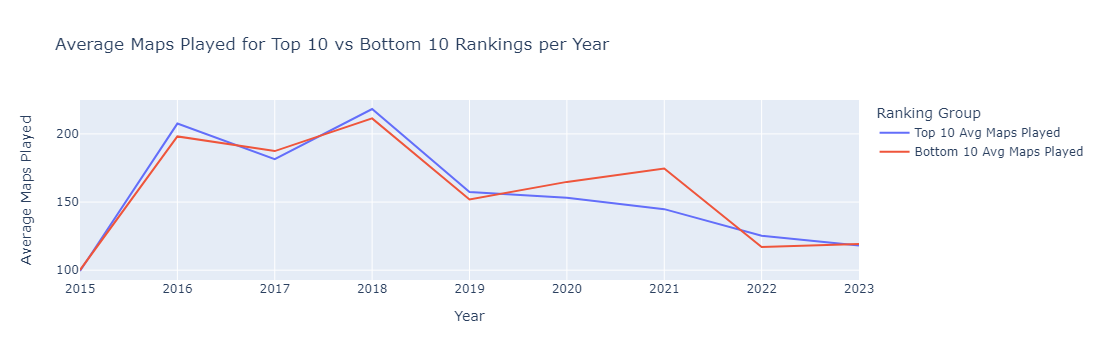

In [77]:
# Compares the average amount of games for the top 10 to the bottom 10
df = pd.read_csv('files/dataframe.csv')

grouped = df.groupby('Year')

# Calculate the mean of the top 10 and bottom 10 rankings for each year
top_10_avg_maps = grouped.apply(lambda x: x.nlargest(10, 'Ranking')['Maps'].mean())
bottom_10_avg_maps = grouped.apply(lambda x: x.nsmallest(10, 'Ranking')['Maps'].mean())

avg_maps_comparison = pd.DataFrame({'Year': top_10_avg_maps.index,
                                     'Top 10 Avg Maps Played': top_10_avg_maps.values,
                                     'Bottom 10 Avg Maps Played': bottom_10_avg_maps.values})

fig = px.line(avg_maps_comparison, x='Year', y=['Top 10 Avg Maps Played', 'Bottom 10 Avg Maps Played'],
              title='Average Maps Played for Top 10 vs Bottom 10 Rankings per Year',
              labels={'value': 'Average Maps Played', 'Year': 'Year', 'variable': 'Ranking Group'})
fig.show()